In [1]:
import pandas as pd
import os
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt

In [2]:
#in this xgboost model, i'm subtracting the features of team 2 from team 1 and storing those values as new feature for the model to learn from. This function is used to create those new features.
def get_differences(df, features, target, private = None):
    
    col_list = []
    for feature in features:
        col_name = f'{feature} Difference'
        team1 = f'Team 1 {feature}'
        team2 = f'Team 2 {feature}'

        df[col_name] = df[team1] - df[team2]

        col_list.append(col_name)


    if private is not None:
        subset = df[df['Team 1 Private School'] == private]
        
        
    else:
        subset = df[df['Team 1 Private School']]
        
    subset = subset[col_list + [target]]
    #change w a 1 and l a 0
    subset[target] = subset[target].apply(lambda x: 1 if x == 'W' else 0)

    X = subset[col_list]
    y = subset[target]


    return X, y

In [3]:
#returns the testing and training splits of the data
def preprocess(X, target, test_size = 0.2, random_state = 42):
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

    # Drop rows where y_train is NaN
    X_train = X_train[~y_train.isna()]
    y_train = y_train.dropna()

    # Ensure that the indices are aligned
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)

    return X_train, X_test, y_train, y_test

In [4]:
#model uses gridsearchCV to tune hyperparameters and output the most accurate model
from sklearn.metrics import accuracy_score

def tune_xgb_classifier(X_train, y_train, X_test, y_test, param_grid=None, cv=5, scoring='accuracy', verbose=1):
    """
    Perform grid search on an XGBClassifier model to find the best hyperparameters and calculate accuracy on a test set.
    
    Parameters:
    - X_train: Training data (features)
    - y_train: Training labels (target)
    - X_test: Test data (features)
    - y_test: Test labels (target)
    - param_grid: Dictionary containing the hyperparameters to tune (must be provided)
    - cv: Number of cross-validation folds (default is 5)
    - scoring: Scoring metric for evaluating the model (default is 'accuracy')
    - verbose: Verbosity level (default is 1)
    
    Returns:
    - best_params: The best hyperparameters found by grid search
    - best_score: The best score (accuracy) achieved with those hyperparameters
    - test_accuracy: Accuracy on the test set
    """
    # Create the base model
    xgb = XGBClassifier()
    
    if param_grid is not None:
        # Perform grid search
        grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose)
        grid_search.fit(X_train, y_train)
        
        # Get the best parameters and best cross-validation score
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        print(f"Best parameters: {best_params}")
        print(f"Best cross-validation accuracy: {best_score:.2f}")
        
        # Refit the model with the best parameters on the entire training set
        best_model = grid_search.best_estimator_
        
        # Predict on the test set
        y_pred = best_model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)
        print(f'Accuracy on the test set: {test_accuracy * 100:.2f}%')
        
        return best_params, best_score, test_accuracy, best_model
    
    # If no param_grid is provided, fit the default model and calculate accuracy on the test set
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy on the test set: {test_accuracy * 100:.2f}%')
    return None, None, test_accuracy, xgb
    
    

In [5]:
import shap
import matplotlib.pyplot as plt

def shap_plots(model, X_train, plot_type='summary', feature=None, interaction_index=None, school_type = None):
    """
    Create SHAP plots for feature importance using the best model from GridSearchCV.
    
    Parameters:
    - model: The trained model (e.g., the best model from GridSearchCV)
    - X_train: The training data used to calculate SHAP values
    - plot_type: Type of SHAP plot to generate ('summary', 'bar', 'dependence')
    - feature: The feature name or index to plot (required for 'dependence' plot)
    - interaction_index: The index of the second feature to plot for interaction (optional for 'dependence')
    
    Returns:
    - None. The function will display the SHAP plot.
    """
    
    # Create the SHAP explainer for the model
    explainer = shap.TreeExplainer(model)  # Works with tree-based models like XGBoost
    
    # Calculate SHAP values for the training data
    shap_values = explainer.shap_values(X_train)
    
    # Generate the specified SHAP plot
    if plot_type == 'summary':
        # Plot summary plot (default)
        shap.summary_plot(shap_values, X_train)
        
    elif plot_type == 'bar':
        # Plot bar plot of mean absolute SHAP values for feature importance
        shap.summary_plot(shap_values, X_train, plot_type="bar")
        
    elif plot_type == 'dependence':
        # Plot dependence plot for a specific feature
        if feature is None:
            raise ValueError("Feature must be specified for the dependence plot.")
        shap.dependence_plot(feature, shap_values, X_train, interaction_index=interaction_index)
    
    else:
        raise ValueError(f"Invalid plot type: {plot_type}. Use 'summary', 'bar', or 'dependence'.")

    # Show the plot
    if school_type is not None:
        plt.gcf().suptitle(school_type, fontsize=16)
        
    #plt.show()


/opt/anaconda3/envs/research-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Main Function: XGBoost Classifer - Predicting Game Outcome

In [8]:
#preprocess data
pd.set_option('display.max_columns', None)  # Show all columns
os.getcwd()
os.chdir('/Users/rdhir/Documents/maxpreps-data-analysis/Data/Final Dataset')
df = pd.read_csv('final_data.csv')

/var/folders/vl/lnfg4f0d5872pfxx4dys19km0000gn/T/ipykernel_68674/2287914788.py:5: DtypeWarning: Columns (38,67) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('final_data.csv')


In [13]:
#right now whoever wins is being reported in the home team category
df.loc[df['Outcome'] == 'L', ['Team 1 Score', 'Team 2 Score']] = df.loc[df['Outcome'] == 'L', ['Team 2 Score', 'Team 1 Score']].values

In [ ]:
#right now whoever wins is being reported in the home team category
df.loc[df['Venue'] == 'L', ['Team 1 Score', 'Team 2 Score']] = df.loc[df['Outcome'] == 'L', ['Team 2 Score', 'Team 1 Score']].values

In [18]:
# Calculate differences for the features you're including
df['SOS Difference'] = df['Team 1 SOS'] - df['Team 2 SOS']
#df['Free Lunch Difference'] = df['Team 1 Free and Reduced Lunch'] - df['Team 2 Free and Reduced Lunch']
df['Pupil/Teacher Ratio Difference'] = df['Team 1 Pupil/Teacher Ratio'] - df['Team 2 Pupil/Teacher Ratio']
df['Grades 9-12 Difference'] = df['Team 1 Grades 9-12 Students'] - df['Team 2 Grades 9-12 Students']
df['Bachelor Degree Difference'] = df['Team 1 Bachelor Degree'] - df['Team 2 Bachelor Degree']
df['Median Household Income Difference'] = df['Team 1 Median Household Income'] - df['Team 2 Median Household Income']

# Calculate racial demographic differences
df['Hispanic Difference'] = df['Team 1 Hispanic'] - df['Team 2 Hispanic']
df['Black Difference'] = df['Team 1 Black'] - df['Team 2 Black']
df['White Difference'] = df['Team 1 White'] - df['Team 2 White']
df['Asian Difference'] = df['Team 1 Asian or Asian/Pacific Islander'] - df['Team 2 Asian or Asian/Pacific Islander']
df['American Indian Difference'] = df['Team 1 American Indian/Alaska Native'] - df['Team 2 American Indian/Alaska Native']

# Select features and target
subset = df[['Outcome', 'SOS Difference', 'Pupil/Teacher Ratio Difference',
        'Grades 9-12 Difference', 'Bachelor Degree Difference', 'Median Household Income Difference', 'Hispanic Difference', 
        'Black Difference', 'White Difference', 'Asian Difference', 'American Indian Difference']].dropna()  #'Free Lunch Difference',

X = subset.drop('Outcome', axis=1)

# Convert 'Outcome' column to binary values
subset['Outcome'] = subset['Outcome'].map({'W': 1, 'L': 0})  # Assuming 'W' is Win and 'L' is Lose

y = subset['Outcome']

In [21]:
X_train, X_test, y_train, y_test = preprocess(X, y) #get the test and train splits

In [23]:
# Define a parameter grid
param_grid = {
    'max_depth': [3, 5, 7], #try 15
    'learning_rate': [0.01, 0.1, 0.2], #try 0.1
    'n_estimators': [100, 200, 300], #100
    'subsample': [0.8, 0.9, 1.0], #90
    'colsample_bytree': [0.8, 0.9, 1.0] #90
}

# Create a base model
xgb = XGBClassifier()

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and accuracy
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best accuracy: {grid_search.best_score_}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}
Best accuracy: 0.6501866580100633


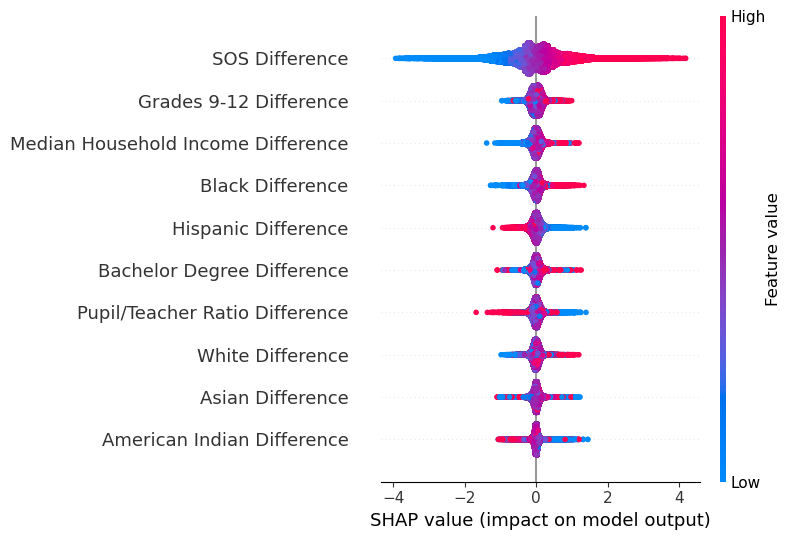

In [31]:

# Use the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Create a SHAP explainer using the best model
explainer = shap.TreeExplainer(best_model)  # Since XGBoost is a tree-based model

# Calculate SHAP values for the training data
shap_values = explainer.shap_values(X_train)

# Plot the SHAP summary plot to show feature importance
shap.summary_plot(shap_values, X_train)

### Public Schools only - XGBClassifier

In [17]:
#preprocess data
features = ['SOS', 'Pupil/Teacher Ratio',
        'Grades 9-12 Students', 'Free and Reduced Lunch', 'Bachelor Degree', 'Median Household Income', 'Hispanic', 
        'Black', 'White', 'Asian or Asian/Pacific Islander', 'American Indian/Alaska Native']
target = 'Outcome'

X, y = get_differences(df, features, target)

X_train, X_test, y_train, y_test = preprocess(X, y)

# Define a parameter grid
param_grid = {
    'max_depth': [3, 5, 7], #try 15
    'learning_rate': [0.01, 0.05, 0.1], #try 0.1
    'n_estimators': [25, 50, 100], #100
    'subsample': [0.5, 0.7, 0.9], #90
    'colsample_bytree': [0.5, 0.7, 0.9] #90
}


# Use GridSearchCV to search for the best hyperparameters
best_params, best_score = tune_xgb_classifier(X_train, y_train, param_grid)

/var/folders/vl/lnfg4f0d5872pfxx4dys19km0000gn/T/ipykernel_29119/1963387328.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[target] = subset[target].apply(lambda x: 1 if x == 'W' else 0)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.9}
Best accuracy: 0.6321636212268443


In [25]:
#without hyperparameter tuning
tuned = tune_xgb_classifier(X_train, y_train, X_test, y_test)
model = tuned[3]

Accuracy on the test set: 63.29%


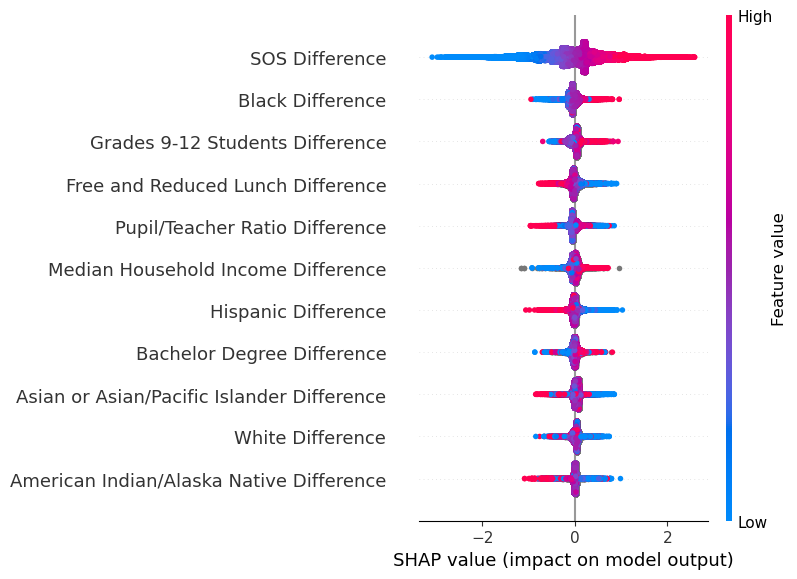

In [26]:
#feature importance
shap_plots(model, X_train, plot_type='summary')

### Private Schools only - XGBClassifier

In [35]:
#preprocess data
features = ['SOS', 'Pupil/Teacher Ratio',
        'Grades 9-12 Students', 'Bachelor Degree', 'Median Household Income', 'Hispanic', 
        'Black', 'White', 'Asian or Asian/Pacific Islander', 'American Indian/Alaska Native']
target = 'Outcome'

X, y = get_differences(df, features, target, private=1)

X_train, X_test, y_train, y_test = preprocess(X, y)

# Define a parameter grid
param_grid = {
    'max_depth': [3, 5, 7], #try 15
    'learning_rate': [0.01, 0.05, 0.1], #try 0.1
    'n_estimators': [100, 125, 150], #100
    'subsample': [0.5, 0.7, 0.9], #90
    'colsample_bytree': [0.5, 0.7, 0.9] #90
}


# Use GridSearchCV to search for the best hyperparameters
best_params, best_score, test_accuracy, best_model = tune_xgb_classifier(X_train, y_train, X_test, y_test, param_grid)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/opt/anaconda3/envs/research-env/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.9}
Best cross-validation accuracy: 0.66
Accuracy on the test set: 67.00%


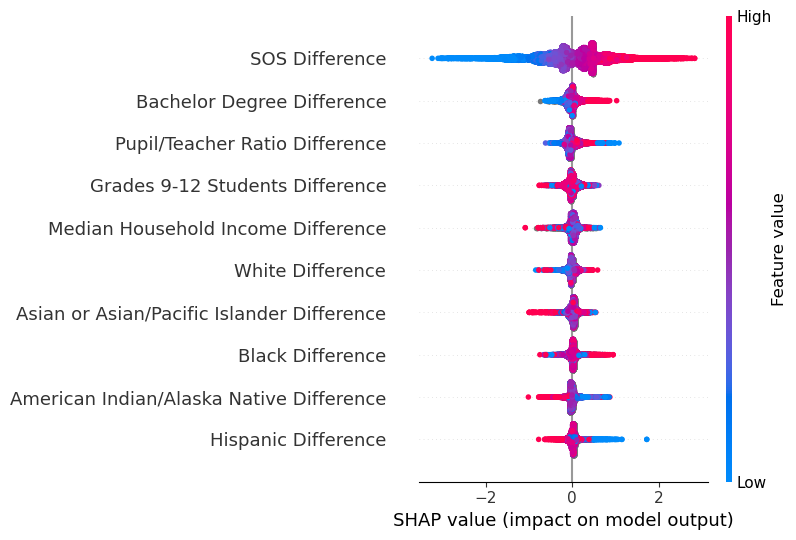

<Figure size 640x480 with 0 Axes>

In [46]:
shap_plots(best_model, X_train, plot_type='summary', school_type='Private School')